In [16]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

In [44]:
# Load train and test datasets
train_data = pd.read_csv('/content/train_mfcc_features (1).csv')  # Update with actual path
test_data = pd.read_csv('/content/test_mfcc_features (1).csv')    # Update with actual path


In [45]:
# Separate features and labels for train data
X_train = train_data.iloc[:, :-1].values  # All columns except 'label'
y_train = train_data['label'].values      # 'label' column

# Separate features and labels for test data
X_test = test_data.iloc[:, :-1].values  # All columns except 'label'
y_test = test_data['label'].values      # 'label' column


In [46]:
from sklearn.utils import class_weight
import numpy as np

# Calculate class weights
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))
print(class_weights)


{0: 1.746031746031746, 1: 2.5, 2: 1.5277777777777777, 3: 0.36065573770491804, 4: 1.6666666666666667}


In [47]:
# Calculate shift mean using NumPy
shift_mean_train = np.mean(np.diff(X_train, axis=1), axis=1).reshape(-1, 1)
shift_mean_test = np.mean(np.diff(X_test, axis=1), axis=1).reshape(-1, 1)

# Calculate RMS mean using NumPy
rms_mean_train = np.sqrt(np.mean(X_train ** 2, axis=1)).reshape(-1, 1)
rms_mean_test = np.sqrt(np.mean(X_test ** 2, axis=1)).reshape(-1, 1)

# Append shift mean and RMS mean as new features to X_train and X_test
X_train = np.hstack((X_train, shift_mean_train, rms_mean_train))
X_test = np.hstack((X_test, shift_mean_test, rms_mean_test))


In [48]:
# Encode labels as integers for categorical cross-entropy
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [49]:
# Convert labels to categorical format for neural network output
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [50]:
# Reshape X data to fit Conv1D input shape (samples, timesteps, features)
# We assume 20 features (18 MFCCs + 2 extra features: shift mean and RMS mean)
X_train_reshaped = X_train.reshape(-1, 20, 1)
X_test_reshaped = X_test.reshape(-1, 20, 1)


In [51]:
from sklearn.model_selection import train_test_split

# Split train data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_reshaped, y_train, test_size=0.2, random_state=42)

# Print shapes to verify the split
print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Validation labels shape: {y_val.shape}")


Training data shape: (440, 20, 1)
Validation data shape: (110, 20, 1)
Training labels shape: (440, 5)
Validation labels shape: (110, 5)


In [52]:
# Define the 1D CNN model
model = Sequential([
    Conv1D(32, kernel_size=3, activation='relu', input_shape=(20, 1)),
    MaxPooling1D(pool_size=2),
    Conv1D(64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(y_train.shape[1], activation='softmax')  # Output layer matching number of classes
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 18, 32)            128       
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, 9, 32)             0         
 g1D)                                                            
                                                                 
 conv1d_7 (Conv1D)           (None, 7, 64)             6208      
                                                                 
 max_pooling1d_7 (MaxPoolin  (None, 3, 64)             0         
 g1D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 192)               0         
                                                                 
 dense_6 (Dense)             (None, 64)              

In [60]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization

# Define the revised 1D CNN model
model = Sequential([
    Conv1D(32, kernel_size=3, activation='relu', input_shape=(20, 1)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    Conv1D(64, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(y_train.shape[1], activation='softmax')  # Output layer
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Summary
model.summary()


Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_10 (Conv1D)          (None, 18, 32)            128       
                                                                 
 batch_normalization_3 (Bat  (None, 18, 32)            128       
 chNormalization)                                                
                                                                 
 max_pooling1d_10 (MaxPooli  (None, 9, 32)             0         
 ng1D)                                                           
                                                                 
 dropout_3 (Dropout)         (None, 9, 32)             0         
                                                                 
 conv1d_11 (Conv1D)          (None, 7, 64)             6208      
                                                                 
 batch_normalization_4 (Bat  (None, 7, 64)           

In [84]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(20, 1)),
    MaxPooling1D(pool_size=2),
    Conv1D(128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),  # Prevent overfitting
    Dense(5, activation='softmax')  # Assuming 5 output classes
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Summary
model.summary()



Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_22 (Conv1D)          (None, 18, 64)            256       
                                                                 
 max_pooling1d_22 (MaxPooli  (None, 9, 64)             0         
 ng1D)                                                           
                                                                 
 conv1d_23 (Conv1D)          (None, 7, 128)            24704     
                                                                 
 max_pooling1d_23 (MaxPooli  (None, 3, 128)            0         
 ng1D)                                                           
                                                                 
 flatten_12 (Flatten)        (None, 384)               0         
                                                                 
 dense_24 (Dense)            (None, 128)             

In [141]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential

model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(20, 1),
           kernel_regularizer=regularizers.l2(0.01)),  # L2 regularization on Conv1D layer
    MaxPooling1D(pool_size=2),

    Conv1D(128, kernel_size=3, activation='relu',
           kernel_regularizer=regularizers.l2(0.01)),  # L2 regularization on Conv1D layer
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(128, activation='relu',
          kernel_regularizer=regularizers.l2(0.01)),  # L2 regularization on Dense layer
    Dropout(0.3),  # Prevent overfitting
    Dense(5, activation='softmax')  # Assuming 5 output classes
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Summary
model.summary()


Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_52 (Conv1D)          (None, 18, 64)            256       
                                                                 
 max_pooling1d_52 (MaxPooli  (None, 9, 64)             0         
 ng1D)                                                           
                                                                 
 conv1d_53 (Conv1D)          (None, 7, 128)            24704     
                                                                 
 max_pooling1d_53 (MaxPooli  (None, 3, 128)            0         
 ng1D)                                                           
                                                                 
 flatten_27 (Flatten)        (None, 384)               0         
                                                                 
 dense_54 (Dense)            (None, 128)             

In [142]:
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import Adam
import numpy as np

# Define the learning rate schedule function
def lr_schedule(epoch):
    initial_lr = 0.001  # Set your initial learning rate here
    drop_factor = 0.5
       # Factor to decrease learning rate
    drop_every = 10     # Drop every 10 epochs
    lr = initial_lr * (drop_factor ** (epoch // drop_every))
    return lr

# Create the learning rate scheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule)

In [143]:
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=8,
    validation_data=(X_val, y_val),
    class_weight=class_weights,
    callbacks=[lr_scheduler]  # Add the scheduler to the callbacks list
)

Epoch 1/50
55/55 [==============================] - 1s 6ms/step - loss: 4.8359 - accuracy: 0.2705 - val_loss: 3.4289 - val_accuracy: 0.3000 - lr: 0.0010
Epoch 2/50
55/55 [==============================] - 0s 3ms/step - loss: 3.3165 - accuracy: 0.3705 - val_loss: 3.0914 - val_accuracy: 0.4182 - lr: 0.0010
Epoch 3/50
55/55 [==============================] - 0s 3ms/step - loss: 2.9742 - accuracy: 0.4477 - val_loss: 2.8600 - val_accuracy: 0.4273 - lr: 0.0010
Epoch 4/50
55/55 [==============================] - 0s 3ms/step - loss: 2.7298 - accuracy: 0.4705 - val_loss: 2.8563 - val_accuracy: 0.3182 - lr: 0.0010
Epoch 5/50
55/55 [==============================] - 0s 3ms/step - loss: 2.5963 - accuracy: 0.4500 - val_loss: 2.5738 - val_accuracy: 0.4273 - lr: 0.0010
Epoch 6/50
55/55 [==============================] - 0s 3ms/step - loss: 2.4618 - accuracy: 0.4864 - val_loss: 2.6294 - val_accuracy: 0.2727 - lr: 0.0010
Epoch 7/50
55/55 [==============================] - 0s 3ms/step - loss: 2.3146 - a

In [144]:
# Evaluate on the test set after training
loss, accuracy = model.evaluate(X_test_reshaped, y_test, verbose=0)
print(f"Test Accuracy: {accuracy:.2f}")

Test Accuracy: 0.70


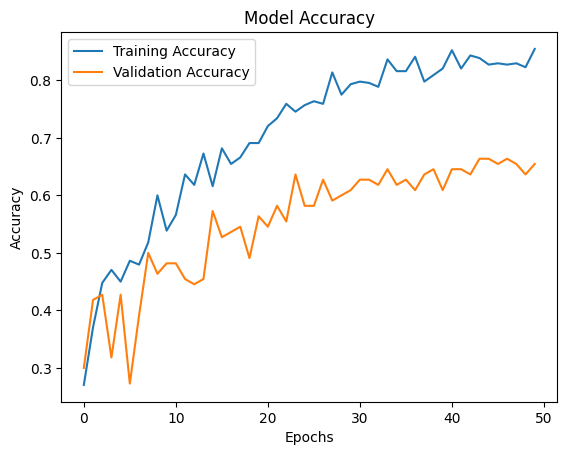

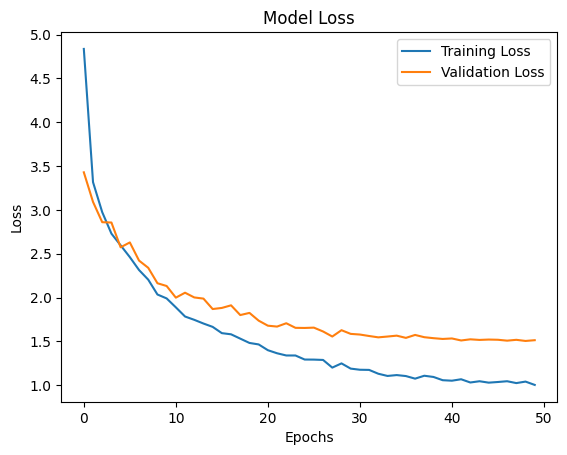

In [145]:
# Plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [146]:
# Save the entire model (architecture + weights)
model.save('my_model.h5')  # Save as H5 file (or use `.tf` for TensorFlow SavedModel format)


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [148]:
import pickle
# Save the model weights and architecture with pickle
def save_model(model, filename):
    with open(filename, 'wb') as f:
        pickle.dump(model, f)

# Save the model
save_model(model, 'my_model.pkl')
